# Incident Neutron Energy Spectrum After First Wall Effects

In [95]:
import openmc
import os, sys
from pathlib import Path
import numpy as np

# Import helper functions
sys.path.insert(0, f"{Path.cwd()}/helper")
from utilities import *

In [96]:
""" MATERIALS """
""" Tungsten """
tungsten = openmc.Material(name='W', temperature=900)
tungsten.add_element('O',5/1e6,percent_type='wo')
tungsten.add_element('N',5/1e6,percent_type='wo')
tungsten.add_element('C',5/1e6,percent_type='wo')
tungsten.add_element('Na',4/1e6,percent_type='wo')
tungsten.add_element('K',2.5/1e6,percent_type='wo')
tungsten.add_element('Al',3/1e6,percent_type='wo')
tungsten.add_element('Ca',0.5/1e6,percent_type='wo')
tungsten.add_element('Cr',0.5/1e6,percent_type='wo')
tungsten.add_element('Cu',0.5/1e6,percent_type='wo')
tungsten.add_element('Fe',5/1e6,percent_type='wo')

tungsten.add_element('W',1-(5+5+5+4+2.5+3+0.5+0.5+0.5+5)/1e6,percent_type='wo')
tungsten.set_density('g/cm3',19.3)
#tungsten.volume = 65636 #Wedge vol
tungsten.depletable = False

""" V-4Cr-4Ti """
vcrti = openmc.Material(name='V-4Cr-4Ti VV', temperature=900)
vcrti.depletable = False

vcrti.add_element('Cr',0.04,percent_type='wo')
vcrti.add_element('Ti',0.04,percent_type='wo')

vcrti.add_element('C',56/1e6,percent_type='wo')
vcrti.add_element('O',181/1e6,percent_type='wo')
vcrti.add_element('N',103/1e6,percent_type='wo')
vcrti.add_element('B',7/1e6,percent_type='wo')
vcrti.add_element('Na',17/1e6,percent_type='wo')
vcrti.add_element('Mg',0.5/1e6,percent_type='wo')
vcrti.add_element('Al',119/1e6,percent_type='wo')
vcrti.add_element('Si',280/1e6,percent_type='wo')
vcrti.add_element('Mn',0.5/1e6,percent_type='wo')
vcrti.add_element('Fe',80/1e6,percent_type='wo')
vcrti.add_element('Ni',13/1e6,percent_type='wo')
vcrti.add_element('Cu',4/1e6,percent_type='wo')
vcrti.add_element('V',1-0.04-0.04-(56+181+103+7+17+0.5+119+280+0.5+80+13+4)/1e6,percent_type='wo')
vcrti.set_density('g/cm3',6.05) 

materials = openmc.Materials([tungsten,vcrti])

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

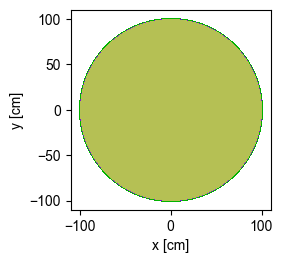

In [104]:
"""GEOMETRY"""
'''first wall slab thickness approximations from balls simplified model
but we are ignoring the effects of imbeded structural components within the flibe mixture
such as the channel structures, RF heating, and vacuum systems.'''

plasma_r = 100 # cm
tung_t = 0.3 # cm
vcrti_t = 1

r0 = openmc.Sphere(r=plasma_r) 
r1 = openmc.Sphere(r=plasma_r+tung_t)
r2 = openmc.Sphere(r=plasma_r+tung_t+vcrti_t, boundary_type='vacuum')

plasma_region = -r0
tung_region   = +r0 & -r1
vcrti_region  = +r1 & -r2

plasma_cell = openmc.Cell(fill=None, region=plasma_region)
tung_cell = openmc.Cell(fill=tungsten, region=tung_region)
vcrti_cell = openmc.Cell(fill=vcrti, region=vcrti_region)

root_univ = openmc.Universe(cells=[plasma_cell, tung_cell, vcrti_cell]) # Create root universe with all material cells
geometry = openmc.Geometry(root_univ)
root_univ.plot(width=(220,220)) # Visualize

In [98]:
""" TALLIES """
tallies = openmc.Tallies() # initialize

# Filters
E_bin_edges = logspace_per_decade(1e-5, 20e6, 100) # './helpers/utilities.py'
energy_filter = openmc.EnergyFilter(E_bin_edges)

surface_filter = openmc.SurfaceFilter(r2)

# Current tally to measure outgoing neutron spectrum
out_tally = openmc.Tally(name='outgoing_spectrum')
out_tally.filters = [surface_filter, energy_filter]
out_tally.scores = ['current']

tallies = openmc.Tallies([out_tally])

In [99]:
""" SETTINGS """
settings = openmc.Settings()

""" Source - isotropic 14.07 MeV """
source = openmc.IndependentSource()
source.space = openmc.stats.Point((0,0,0)) 
source.angle = openmc.stats.Isotropic()     
source.energy = openmc.stats.Discrete([14.07e6], [1.0])  
settings.source = source

""" Run type """
settings.run_mode = 'fixed source'
settings.particles = int(1e7)
settings.batches = 100

In [100]:
model = openmc.model.Model(geometry, materials, settings, tallies)
model.export_to_model_xml("./model_FirstWall_V1cm_900K_2025-07-22/")
results = model.run(cwd="./model_FirstWall_V1cm_900K_2025-07-22/")  

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [102]:
import pandas as pd 

sp = openmc.StatePoint(f'./model_FirstWall_V1cm_900K_2025-07-22/statepoint.100.h5') 
tally = sp.get_tally(name='outgoing_spectrum')
print(tally)
df = tally.get_pandas_dataframe()

# Add new column for energy bin midpoint (for plotting)
df['energy mid [eV]'] = (df['energy low [eV]'] + df['energy high [eV]'])/ 2
print(df)
df.to_csv("firstwall_V1cm_900K_2025-07-22.csv", index=False)


Tally
	ID             =	9
	Name           =	outgoing_spectrum
	Filters        =	SurfaceFilter, EnergyFilter
	Nuclides       =	total
	Scores         =	['current']
	Estimator      =	analog
	Multiply dens. =	True
      surface  energy low [eV]  energy high [eV] nuclide    score     mean  \
0          61         1.00e-05          1.02e-05   total  current 0.00e+00   
1          61         1.02e-05          1.05e-05   total  current 0.00e+00   
2          61         1.05e-05          1.07e-05   total  current 0.00e+00   
3          61         1.07e-05          1.10e-05   total  current 0.00e+00   
4          61         1.10e-05          1.12e-05   total  current 0.00e+00   
...       ...              ...               ...     ...      ...      ...   
1226       61         1.78e+07          1.82e+07   total  current 0.00e+00   
1227       61         1.82e+07          1.87e+07   total  current 0.00e+00   
1228       61         1.87e+07          1.91e+07   total  current 0.00e+00   
1229      